In [ ]:
!pip install imbalanced-learn

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [ ]:
# 3. Baca dataset
df = pd.read_csv('/content/drive/MyDrive/Tugas ML/diabetes.csv')

# 4. Ambil hanya 4 fitur penting
selected_features = ['Glucose', 'BMI', 'Age', 'Insulin', 'Outcome']
df = df[selected_features]

In [ ]:
# 5. Nilai 0 jadi NaN untuk fitur tertentu
for col in ['Glucose', 'BMI', 'Insulin']:
    df[col] = df[col].replace(0, np.nan)

# 6. Imputasi nilai NaN dengan median
imputer = SimpleImputer(strategy='median')
df[['Glucose', 'BMI', 'Insulin']] = imputer.fit_transform(df[['Glucose', 'BMI', 'Insulin']])

# 7. Pisahkan fitur dan label
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [ ]:
# 8. Split data train/test (sebelum normalisasi dan oversampling agar tidak ada data leak)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 9. Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# 10. Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_train)

In [ ]:
# SVM - Grid search untuk hyperparameter tuning
# Parameter yang akan diuji
param_grid_svm = {
    'C': [0.1, 1, 10, 100],              # regularization
    'kernel': ['rbf', 'poly'], # jenis kernel
    'gamma': [0.01, 0.1, 1]           # untuk rbf/poly
}

# Inisialisasi model SVM
svm = SVC(random_state=42)

# Grid Search
grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    cv=10,
    scoring='f1',
    verbose=3
)

# Fit ke data
grid_svm.fit(X_scaled, y_train)

# Hasil terbaik
print("Best SVM Params:", grid_svm.best_params_)

# Simpan model terbaik
model_svm = grid_svm.best_estimator_

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10] END ....C=0.1, gamma=0.01, kernel=rbf;, score=0.000 total time=   0.0s
[CV 2/10] END ....C=0.1, gamma=0.01, kernel=rbf;, score=0.000 total time=   0.0s
[CV 3/10] END ....C=0.1, gamma=0.01, kernel=rbf;, score=0.000 total time=   0.0s
[CV 4/10] END ....C=0.1, gamma=0.01, kernel=rbf;, score=0.000 total time=   0.0s
[CV 5/10] END ....C=0.1, gamma=0.01, kernel=rbf;, score=0.000 total time=   0.0s
[CV 6/10] END ....C=0.1, gamma=0.01, kernel=rbf;, score=0.000 total time=   0.0s
[CV 7/10] END ....C=0.1, gamma=0.01, kernel=rbf;, score=0.000 total time=   0.0s
[CV 8/10] END ....C=0.1, gamma=0.01, kernel=rbf;, score=0.000 total time=   0.0s
[CV 9/10] END ....C=0.1, gamma=0.01, kernel=rbf;, score=0.000 total time=   0.0s
[CV 10/10] END ...C=0.1, gamma=0.01, kernel=rbf;, score=0.000 total time=   0.1s
[CV 1/10] END ...C=0.1, gamma=0.01, kernel=poly;, score=0.000 total time=   0.0s
[CV 2/10] END ...C=0.1, gamma=0.01, kernel=pol

In [ ]:
# 10. Evaluasi model
y_pred = model_svm.predict(X_scaled_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["Negatif", "Positif"]))
print("Akurasi:", accuracy_score(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

     Negatif       0.79      0.84      0.82       150
     Positif       0.67      0.59      0.63        81

    accuracy                           0.75       231
   macro avg       0.73      0.72      0.72       231
weighted avg       0.75      0.75      0.75       231

Akurasi: 0.7532467532467533


In [ ]:
# Cek overfit
y_train_pred = model_svm.predict(X_scaled)

print("\n=== Classification Report ===")
print(classification_report(y_train, y_train_pred, target_names=["Negatif", "Positif"]))
print("Akurasi:", accuracy_score(y_train, y_train_pred))


=== Classification Report ===
              precision    recall  f1-score   support

     Negatif       0.85      0.91      0.88       350
     Positif       0.81      0.70      0.75       187

    accuracy                           0.84       537
   macro avg       0.83      0.81      0.82       537
weighted avg       0.84      0.84      0.84       537

Akurasi: 0.839851024208566


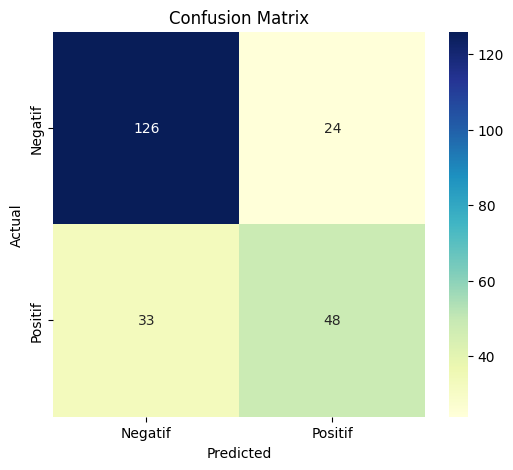

In [ ]:
# 11. Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cmap='YlGnBu', xticklabels=["Negatif", "Positif"], yticklabels=["Negatif", "Positif"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()